In [1]:
import pickle
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedKFold, LeaveOneOut
from sklearn.mixture import GaussianMixture
from sklearn.cluster import KMeans
from models import Net
import torch
from torch import nn
import torch.optim as optim
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from utils.eval import get_eval_metrics
from torch.utils.data import TensorDataset, DataLoader

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
xs = np.stack(pickle.load(open( "aal_time_series_nyu_150.pkl", "rb")))
ys = np.stack(pickle.load(open( "aal_time_series_nyu_150_labels.pkl", "rb")))

#xs_train, xs_test, ys_train, ys_test = train_test_split(xs, ys, stratify=ys, test_size=0.3, random_state=42)

In [3]:
def get_samples(xs, ys):
    classes = [0, 1]
    anchors = []
    positives = []
    negatives = []

    for c in classes:
        # construct anchors from batch
        anchors.append(torch.tensor(xs[ys == c].reshape(-1, xs.shape[-1])).float())
        
        # pick postive samples randomly from dataset
        pos_idx = torch.randint(0, len(xs[ys == c]), (len(anchors[-1]),))
        positives.append(torch.tensor(xs[ys == c].reshape(-1, xs.shape[-1]))[pos_idx].float())
        
        # pick negative samples randomly from dataset
        neg_idx = torch.randint(0, len(xs[ys != c]), (len(anchors[-1]),))
        negatives.append(torch.tensor(xs[ys != c].reshape(-1, xs.shape[-1]))[neg_idx].float())

    anchors = torch.vstack(anchors)
    positives = torch.vstack(positives)
    negatives = torch.vstack(negatives)

    return anchors, positives, negatives

def get_gmm_metrics(xs_train, ys_train, xs_test, ys_test, n_states):
    xs_control_train = np.stack([x for (x, y) in zip(xs_train, ys_train) if y == 0])
    xs_disease_train = np.stack([x for (x, y) in zip(xs_train, ys_train) if y == 1])

    # Reshape data for GMM
    zs_control_train_in = net(torch.tensor(xs_control_train.reshape(-1, xs_control_train.shape[-1])).float().cuda()).detach().cpu()
    zs_disease_train_in = net(torch.tensor(xs_disease_train.reshape(-1, xs_disease_train.shape[-1])).float().cuda()).detach().cpu()
    
    zs_train = net(torch.tensor(xs_train.reshape(-1, xs_train.shape[-1])).float().cuda()).detach().cpu()
    zs_train = zs_train.reshape(xs_train.shape[0], xs_train.shape[1], z_dim)

    zs_test = net(torch.tensor(xs_test.reshape(-1, xs_test.shape[-1])).float().cuda()).detach().cpu()
    zs_test = zs_test.reshape(xs_test.shape[0], xs_test.shape[1], z_dim)


    # Train model (under the hood K-means initialization)
    gm_control = GaussianMixture(n_components=n_states, verbose=0, n_init=1).fit(zs_control_train_in)
    gm_disease = GaussianMixture(n_components=n_states, verbose=0).fit(zs_disease_train_in)

    # Evaluate model
    # compute log likelihood for each subject under both models
    train_ll = np.stack([[gm_control.score(z), gm_disease.score(z) ]for z in zs_train])
    y_train_pred = np.argmax(train_ll, 1)

    train_metrics = get_eval_metrics(ys_train, y_train_pred)
    
    test_ll = np.stack([[gm_control.score(z), gm_disease.score(z) ]for z in zs_test])
    y_test_pred = np.argmax(test_ll, 1)

    test_metrics = get_eval_metrics(ys_test, y_test_pred)

    return train_metrics, test_metrics

In [4]:
n_states = 4
n_epochs = 300
n_samps = 1

use_cuda = True
z_dim = 10
x_dim = 116

kf = StratifiedKFold(n_splits=10)

device = torch.device("cuda" if use_cuda else "cpu")
net = Net(x_dim=x_dim, z_dim=z_dim).to(device)

optimizer = optim.Adam(net.parameters(), lr=0.01)
triplet_loss = nn.TripletMarginLoss(margin=2.0, p=2)

In [5]:
losses = []
ho_losses = []
train_metrics_lst = []
test_metrics_lst = []

for i, (train_index, test_index) in enumerate(kf.split(xs, ys)):
    losses.append([])
    ho_losses.append([])
    train_metrics_lst.append([])
    test_metrics_lst.append([])

    print(f'Fold {i+1} of 10')
    xs_train, xs_test = xs[train_index], xs[test_index]
    ys_train, ys_test = ys[train_index], ys[test_index]


    for i in range(n_epochs):
        if i % 20 == 0:
            print(f'{i+1} of {n_epochs}')
        
        optimizer.zero_grad()
        net.train()
        
        loss = 0
        
        for j in range(n_samps):
            anchors, positives, negatives = get_samples(xs_train, ys_train)
            a, p, n = net(anchors.cuda()), net(positives.cuda()), net(negatives.cuda())
            loss += triplet_loss(a, p, n)
        
        loss = loss/n_samps
        loss.backward()
        optimizer.step()
        losses[-1].append(loss.item())

        net.eval()

        for j in range(n_samps):
            anchors, positives, negatives = get_samples(xs_test, ys_test)
            a, p, n = net(anchors.cuda()), net(positives.cuda()), net(negatives.cuda())
            loss += triplet_loss(a, p, n)
        
        loss = loss/n_samps
        ho_losses[-1].append(loss.item())

        if i % 50 == 0:
            train_metrics, test_metrics = get_gmm_metrics(xs_train, ys_train, xs_test, ys_test, n_states)
            #print(train_metrics)
            #print(test_metrics)
            train_metrics_lst[-1].append(train_metrics)
            test_metrics_lst[-1].append(test_metrics)

Fold 1 of 10
1 of 300
21 of 300
41 of 300
61 of 300
81 of 300
101 of 300
121 of 300
141 of 300
161 of 300
181 of 300
201 of 300
221 of 300
241 of 300
261 of 300
281 of 300
Fold 2 of 10
1 of 300
21 of 300
41 of 300
61 of 300
81 of 300
101 of 300
121 of 300
141 of 300
161 of 300
181 of 300
201 of 300
221 of 300
241 of 300
261 of 300
281 of 300
Fold 3 of 10
1 of 300
21 of 300
41 of 300
61 of 300
81 of 300
101 of 300
121 of 300
141 of 300
161 of 300
181 of 300
201 of 300
221 of 300
241 of 300
261 of 300
281 of 300
Fold 4 of 10
1 of 300
21 of 300
41 of 300
61 of 300
81 of 300
101 of 300
121 of 300
141 of 300
161 of 300
181 of 300
201 of 300
221 of 300
241 of 300
261 of 300
281 of 300
Fold 5 of 10
1 of 300
21 of 300
41 of 300
61 of 300
81 of 300
101 of 300
121 of 300
141 of 300
161 of 300
181 of 300
201 of 300
221 of 300
241 of 300
261 of 300
281 of 300
Fold 6 of 10
1 of 300
21 of 300
41 of 300
61 of 300
81 of 300
101 of 300
121 of 300
141 of 300
161 of 300
181 of 300
201 of 300
221 of 300
2

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


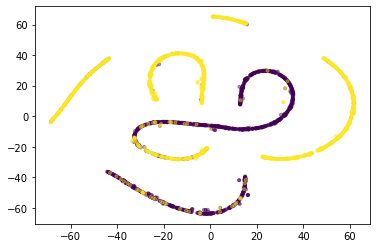

In [6]:
from sklearn.manifold import TSNE

zs = []
zs.append(net(torch.tensor(xs_test[ys_test == 0][:10].reshape(-1, xs_test.shape[-1])).cuda().float()).cpu().detach().numpy())
zs.append(net(torch.tensor(xs_test[ys_test == 1][:10].reshape(-1, xs_test.shape[-1])).cuda().float()).cpu().detach().numpy())
c = np.hstack([np.zeros(len(zs[0])), np.ones(len(zs[1]))])
zs = np.vstack(zs)
zs_embedded = TSNE(n_components=2).fit_transform(zs)

plt.scatter(zs_embedded[:,0], zs_embedded[:,1], c=c, marker='.', alpha=.4)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


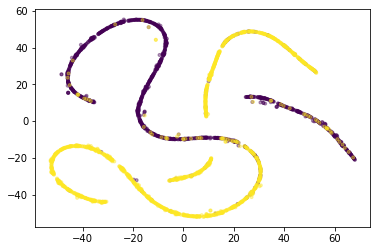

In [7]:
zs = []
zs.append(net(torch.tensor(xs_test[ys_test == 0][:50].reshape(-1, xs_test.shape[-1])).cuda().float()).cpu().detach().numpy())
zs.append(net(torch.tensor(xs_test[ys_test == 1][:50].reshape(-1, xs_test.shape[-1])).cuda().float()).cpu().detach().numpy())

c = np.hstack([np.zeros(len(zs[0])), np.ones(len(zs[1]))])
zs = np.vstack(zs)
zs_embedded = TSNE(n_components=2).fit_transform(zs)

plt.scatter(zs_embedded[:,0], zs_embedded[:,1], c=c, marker='.', alpha=.4)

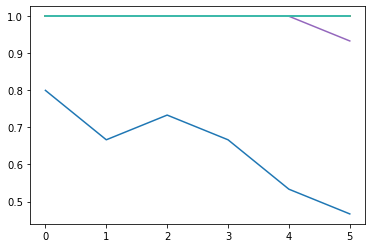

In [8]:
for t in test_metrics_lst:
    plt.plot([tt['acc'] for tt in t])

In [9]:
def get_cv_metrics(cv_results):
    accs = [split['acc'] for split in cv_results]
    sens = [split['sen'] for split in cv_results]
    specs = [split['spe'] for split in cv_results]

    mean_accs, std_accs = np.mean(accs), np.std(accs)
    mean_sen, std_sen = np.mean(sens), np.std(sens)
    mean_spec, std_spec = np.mean(specs), np.std(specs)

    return {'acc_mean': mean_accs, 'acc_std': std_accs, 
            'sen_mean': mean_sen, 'sen_std': std_sen,
            'spec_mean': mean_spec, 'spec_std': std_spec}


cv_results = [t[4] for t in train_metrics_lst]
metrics = get_cv_metrics(cv_results)
vals = list(metrics.values())
print(f'\t{vals[0]:.3f}\u00B1{vals[1]:.3f}' +
      f'\t{vals[2]:.3f}\u00B1{vals[3]:.3f}' +
      f'\t{vals[4]:.3f}\u00B1{vals[5]:.3f}')


cv_results = [t[4] for t in test_metrics_lst]
metrics = get_cv_metrics(cv_results)
vals = list(metrics.values())
print(f'\t{vals[0]:.3f}\u00B1{vals[1]:.3f}' +
      f'\t{vals[2]:.3f}\u00B1{vals[3]:.3f}' +
      f'\t{vals[4]:.3f}\u00B1{vals[5]:.3f}')

	1.000±0.000	1.000±0.000	1.000±0.000
	0.953±0.140	0.914±0.257	0.988±0.037


In [10]:
test_metrics_lst

[[{'acc': 0.8,
   'sen': 0.7142857142857143,
   'spe': 0.875,
   'ppv': 0.8333333333333334,
   'npv': 0.7777777777777778},
  {'acc': 0.6666666666666666,
   'sen': 0.5714285714285714,
   'spe': 0.75,
   'ppv': 0.6666666666666666,
   'npv': 0.6666666666666666},
  {'acc': 0.7333333333333333,
   'sen': 0.5714285714285714,
   'spe': 0.875,
   'ppv': 0.8,
   'npv': 0.7},
  {'acc': 0.6666666666666666,
   'sen': 0.7142857142857143,
   'spe': 0.625,
   'ppv': 0.625,
   'npv': 0.7142857142857143},
  {'acc': 0.5333333333333333,
   'sen': 0.14285714285714285,
   'spe': 0.875,
   'ppv': 0.5,
   'npv': 0.5384615384615384},
  {'acc': 0.4666666666666667,
   'sen': 0.2857142857142857,
   'spe': 0.625,
   'ppv': 0.4,
   'npv': 0.5}],
 [{'acc': 1.0, 'sen': 1.0, 'spe': 1.0, 'ppv': 1.0, 'npv': 1.0},
  {'acc': 1.0, 'sen': 1.0, 'spe': 1.0, 'ppv': 1.0, 'npv': 1.0},
  {'acc': 1.0, 'sen': 1.0, 'spe': 1.0, 'ppv': 1.0, 'npv': 1.0},
  {'acc': 1.0, 'sen': 1.0, 'spe': 1.0, 'ppv': 1.0, 'npv': 1.0},
  {'acc': 1.0, 'se

In [11]:
flattened_test_metrics_lst = [item for sublist in test_metrics_lst for item in sublist]

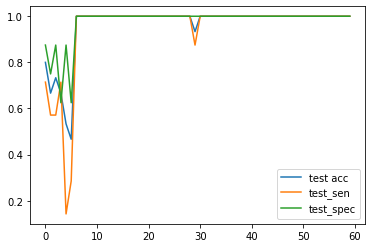

In [12]:
plt.plot([t['acc'] for t in flattened_test_metrics_lst])
plt.plot([t['sen'] for t in flattened_test_metrics_lst])
plt.plot([t['spe'] for t in flattened_test_metrics_lst])
plt.legend(['test acc', 'test_sen', 'test_spec'])

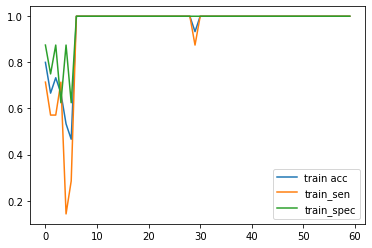

In [13]:
plt.plot([t['acc'] for t in flattened_test_metrics_lst])
plt.plot([t['sen'] for t in flattened_test_metrics_lst])
plt.plot([t['spe'] for t in flattened_test_metrics_lst])
plt.legend(['train acc', 'train_sen', 'train_spec'])

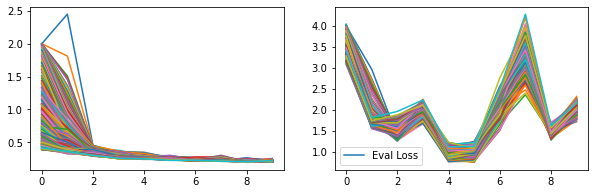

In [14]:
f, ax = plt.subplots(1, 2, figsize=(10,3))
ax[0].plot(losses)
plt.legend(['Train Loss'])
        
ax[1].plot(ho_losses)
plt.legend(['Eval Loss'])

plt.show()

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


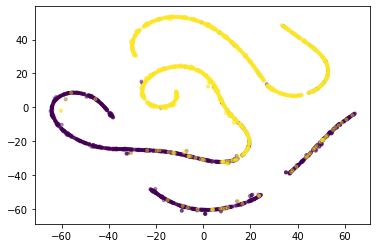

In [15]:
from sklearn.manifold import TSNE

zs = []
zs.append(net(torch.tensor(xs_test[ys_test == 0][:10].reshape(-1, xs_test.shape[-1])).cuda().float()).cpu().detach().numpy())
zs.append(net(torch.tensor(xs_test[ys_test == 1][:10].reshape(-1, xs_test.shape[-1])).cuda().float()).cpu().detach().numpy())
c = np.hstack([np.zeros(len(zs[0])), np.ones(len(zs[1]))])
zs = np.vstack(zs)
zs_embedded = TSNE(n_components=2).fit_transform(zs)

plt.scatter(zs_embedded[:,0], zs_embedded[:,1], c=c, marker='.', alpha=.4)








